# Calculating Overlap in Actual Imagery Coverage Between Baseline and EV Imagery Area 

In [1]:
import pandas as pd
import geopandas as gpd
import sys
sys.path.append('../src/')
import image_coverage as img_cover
import analyze_img_coverage as analyze
from datetime import datetime, timedelta

### Set File Paths

In [2]:
# Polygon geometries and attributes from TM API
polygon_features = '../data/tf_cohort1/tm_api_cohort1_2025-04-02.csv'

# All Maxar imagery & image footprints for polygons
maxar_md = '../data/tf_cohort1/imagery_availability/comb_img_availability_cohort1_2025-04-02.csv'

# Best image availability per polygon
# Baseline
base_img_avail = '../data/tf_cohort1/results/baseline/polygon_imagery_coverage_cohort1_2025-04-02.csv'

# Early Verification (1+ year post-plantstart)
ev_img_avail = '../data/tf_cohort1/results/year_2/polygon_imagery_coverage_cohort1_2025-04-02.csv'

### Read in Files

In [3]:
# Polygon geometries and attributes from TM API
poly_df = pd.read_csv(polygon_features)

# All Maxar imagery & image footprints for polygons
maxar_df = pd.read_csv(maxar_md)

# Best image availability per polygon
# Baseline
base_img_avail_df = pd.read_csv(base_img_avail)

# Early Verification (1+ year post-plantstart)
ev_img_avail_df = pd.read_csv(ev_img_avail)

### Preprocess Polygon & Maxar Data

In [4]:
poly_gdf = img_cover.preprocess_polygons(poly_df, debug=True)
maxar_gdf = img_cover.preprocess_images(maxar_df, debug=True)

Processing polygon data...
Cleaning geometries...

🧾 Geometry Cleaning Summary:
  ➤ Total geometries processed: 13537
  ➤ Invalid geometries:         0
  ➤ Repaired with buffer(0):    0
  ➤ Dropped:                    0
  ✅ Final valid polygons:       13537

Processing Maxar image data...
There are 175641 images for 12168 polygons in 78 projects in this dataset.


## Build Comparison Dataframe

#### Baseline Polygon Image Availability

In [5]:
# Merge in 'poly_geom' from poly_gdf to baseline image availability df
base_img_avail_gdf = gpd.GeoDataFrame(base_img_avail_df.merge(poly_gdf[['poly_id', 'poly_geom']], how='left', on='poly_id'))

In [6]:
# Create lookup table of image geometry associated with each unique maxar image ID
unique_maxar_imgs_gdf = maxar_gdf.drop_duplicates(subset='title')[['title', 'img_geom']]
unique_maxar_imgs_gdf.head(2)

# Merge in 'img_geom' from maxar_gdf lookup table to baseline image availability df
base_img_avail_gdf = base_img_avail_gdf.merge(unique_maxar_imgs_gdf[['title', 'img_geom']], how='left', left_on='best_image', right_on='title')
base_img_avail_gdf[117:120]

,poly_id,project_id,best_image,num_images,poly_area_ha,overlap_area_ha,percent_img_cover,poly_geom,title,img_geom
117,1a10c9f4-4940-4715-93f1-164d57c61eb7,389aad5b-6577-4cea-bf9f-446dcfd94966,Maxar WV02 Image 10300100DE8BBE00,1,0.386625,0.386625,100.0,"POLYGON ((31.19677 1.29141, 31.19678 1.2912, 3...",Maxar WV02 Image 10300100DE8BBE00,"POLYGON ((31.07613 1.51209, 31.07636 1.46413, ..."
118,e967dba5-b2bf-41bb-af68-9c7c59836ab5,389aad5b-6577-4cea-bf9f-446dcfd94966,NaN,0,2.527293,0.000000,0.0,"POLYGON ((31.33516 1.53714, 31.33514 1.53717, ...",NaN,None
119,77af134d-3981-45fc-988b-95c16dc184af,389aad5b-6577-4cea-bf9f-446dcfd94966,Maxar WV02 Image 10300100DFBDF500,2,0.311552,0.311552,100.0,"POLYGON ((31.17725 1.3429, 31.17722 1.34288, 3...",Maxar WV02 Image 10300100DFBDF500,"POLYGON ((31.0339 1.49462, 31.03396 1.45226, 3..."


#### Early Verification Polygon Image Availability

In [7]:
# Merge in 'poly_geom' from poly_gdf to early verification image availability df
ev_img_avail_gdf = gpd.GeoDataFrame(ev_img_avail_df.merge(unique_maxar_imgs_gdf[['title', 'img_geom']], how='left', left_on='best_image', right_on='title'))
ev_img_avail_gdf.head(2)

,poly_id,project_id,best_image,num_images,poly_area_ha,overlap_area_ha,percent_img_cover,title,img_geom
0,a40e322b-42ff-4008-8407-e611b170a39c,389aad5b-6577-4cea-bf9f-446dcfd94966,Maxar WV03 Image 1040010094CD6A00,1,0.231599,0.231599,100.0,Maxar WV03 Image 1040010094CD6A00,"POLYGON ((31.43146 1.84578, 31.43147 1.85154, ..."
1,9dcccf42-cd63-471b-a251-abd1009fb819,389aad5b-6577-4cea-bf9f-446dcfd94966,Maxar WV03 Image 1040010094CD6A00,1,0.467551,0.467551,100.0,Maxar WV03 Image 1040010094CD6A00,"POLYGON ((31.43146 1.84578, 31.43147 1.85154, ..."


#### Combine Baseline & Early Verification Image Availability GeoDataFrames

In [8]:
#Select and rename relevent columns from baseline dataframe
combined_gdf = base_img_avail_gdf[[
    'poly_id', 'project_id', 'poly_geom', 'poly_area_ha', 'best_image', 'img_geom', 'overlap_area_ha', 'percent_img_cover']].copy().rename(columns={
    'best_image': 'best_img_base',
    'img_geom': 'img_geom_base',
    'overlap_area_ha': 'overlap_area_base',
    'percent_img_cover': 'pct_img_cover_base'
})

In [10]:
# Merge in 'best_image' and 'img_geom' from the early verification dataframe
combined_gdf = combined_gdf.merge(ev_img_avail_gdf[[
    'poly_id', 'best_image', 'img_geom', 'overlap_area_ha', 'percent_img_cover']], how='left', on='poly_id').rename(
    columns={
        'best_image': 'best_img_ev',
        'img_geom': 'img_geom_ev',
        'overlap_area_ha': 'overlap_area_ev',
        'percent_img_cover': 'pct_img_cover_ev'
    })

In [12]:
print('length of gdf', len(combined_gdf))
print('poly_geom is NaN:', len(combined_gdf[combined_gdf['poly_geom'].isna()]))
print('img_geom_base is NaN:', len(combined_gdf[combined_gdf['img_geom_base'].isna()]))
print('img_geom_ev is NaN:', len(combined_gdf[combined_gdf['img_geom_ev'].isna()]))
print('img_geom_base OR img_geom_ev is NaN:', len(combined_gdf[(combined_gdf['img_geom_ev'].isna()) | combined_gdf['img_geom_base'].isna()]))
print('images for both baseline & EV:', len(combined_gdf[(~combined_gdf['img_geom_base'].isna()) & (~combined_gdf['img_geom_ev'].isna())]))

length of gdf 13537
poly_geom is NaN: 0
img_geom_base is NaN: 6556
img_geom_ev is NaN: 6738
img_geom_base OR img_geom_ev is NaN: 9784
images for both baseline & EV: 3753


In [ ]:
# def reproject_geometry(geom, target_crs):
#     """
#     Reprojects a single Shapely geometry into the target CRS.

#     Args:
#         - geom (shapely geometry object): A geometry in the form of a shapely object. Expects an input CRS of EPSG:4326
#     Returns:
#         - A shapely object reprojected to the target_crs
#     """
#     gdf = gpd.GeoDataFrame(index=[0], geometry=[geom], crs="EPSG:4326")
#     return gdf.to_crs(target_crs).geometry.iloc[0]

In [ ]:
# def compute_shared_img_overlap(row, debug=False):
#     """
#     Given a row of a DataFrame with a polygon and baseline/early verification image footprints, 
#     calculates the actual area and % of the polygon area that has imagery coverage at both time points.

#     Args:
#         - row: Row in a GeoDataFrame
#     Returns:
#         - pd.Series with the area of the polygon with overlapping imagery (ha) and percent of the polygon with imagery coverage at both time points
#     """
#     from shapely.geometry.base import BaseGeometry

#     if debug:
#         print(f"\n⚙️ Processing poly_id: {row.get('poly_id', 'N/A')}")

#     # Extract row values
#     poly_geom = row['poly_geom']
#     img_geom_base = row['img_geom_base']
#     img_geom_ev = row['img_geom_ev']

#     if debug:
#         print(f"⬜ Geometry types:\n poly={type(poly_geom)},\n base={type(img_geom_base)},\n ev={type(img_geom_ev)}")


#     # Check for missing, empty, or invalid type geometries
#     #  If one or more geometries are missing/invalid, return 0 hectares of overlapping area and 0 % of the polygon with overlapping imagery coverage
#     if not all(isinstance(g, BaseGeometry) and not g.is_empty for g in [poly_geom, img_geom_base, img_geom_ev]):
#         if debug:
#             print(f"⚠️ Missing or invalid type of one or more geometries: recording 0 area & % overlap for poly_id: {row.get('poly_id')}")
#         return pd.Series({'overlap_area_both': 0, 'pct_img_cover_both': 0})
    
#     if debug:
#         print(f"✅ Valid geometries for polygon and both baseline & EV image")
    
#     # Compute UTM Zone based on polygon centroid
#     centroid = poly_geom.centroid
#     utm_crs = img_cover.get_utm_crs(centroid.x, centroid.y)
#     if debug:
#         print(f"🗺️ Calculated UTM CRS: {utm_crs}")

#     try:
#         # Reproject polygon and image geometries for accurate area calculations 
#         #  (Use reproject_geometry function to reproject shapely objects by wrapping them in a one-row GeoDataFrame)
#         poly_proj = reproject_geometry(poly_geom, utm_crs)
#         base_proj = reproject_geometry(img_geom_base, utm_crs)
#         ev_proj = reproject_geometry(img_geom_ev, utm_crs)
    
#         # Calculate intersection of polygon with baseline & early verification image
#         intersection = poly_proj.intersection(base_proj).intersection(ev_proj)
#         overlap_area = intersection.area
#         poly_area = poly_proj.area

#         # Calculate percent of polygon area with imagery at both baseline & early verification
#         percent_covered = (overlap_area / poly_area) if poly_area > 0 else 0

#         if debug:
#             print(f"📐 Polygon area (ha): {poly_area / 10_000}")
#             print(f"🛰️ Area with overlapping imagery (ha): {overlap_area / 10_000}")
#             print(f"✅ Percent of polygon with imagery coverage both years (ha): {percent_covered * 100}")

#         return pd.Series({
#             'overlap_area_both': overlap_area / 10_000,     # in hectares
#             'pct_img_cover_both': percent_covered * 100     # in % of polygon area
#             })
    
#     except Exception as e:
#         if debug:
#             print(f"❌ Exception occurred for poly_id {row.get('poly_id')}: {e}")
#         return pd.Series({'overlap_area_both': 0, 'pct_img_cover_both': 0})

### Apply Function to Calculate Area With Overlapping Imagery Across DataFrame

In [43]:
combined_gdf[['overlap_area_both', 'pct_img_cover_both']] = combined_gdf.apply(
    analyze.compute_shared_img_overlap,
    axis=1
)

In [44]:
combined_gdf[117:120]

,poly_id,project_id,poly_geom,poly_area_ha,best_img_base,img_geom_base,overlap_area_base,pct_img_cover_base,best_img_ev,img_geom_ev,overlap_area_ev,pct_img_cover_ev,overlap_area_both,pct_img_cover_both
117,1a10c9f4-4940-4715-93f1-164d57c61eb7,389aad5b-6577-4cea-bf9f-446dcfd94966,"POLYGON ((31.19677 1.29141, 31.19678 1.2912, 3...",0.386625,Maxar WV02 Image 10300100DE8BBE00,"POLYGON ((31.07613 1.51209, 31.07636 1.46413, ...",0.386625,100.0,Maxar WV02 Image 10300100F9AE3900,"POLYGON ((31.06672 2.03158, 31.06672 2.03089, ...",0.386625,100.0,0.386625,100.0
118,e967dba5-b2bf-41bb-af68-9c7c59836ab5,389aad5b-6577-4cea-bf9f-446dcfd94966,"POLYGON ((31.33516 1.53714, 31.33514 1.53717, ...",2.527293,NaN,None,0.000000,0.0,Maxar WV03 Image 1040010094CD6A00,"POLYGON ((31.43146 1.84578, 31.43147 1.85154, ...",2.527293,100.0,0.000000,0.0
119,77af134d-3981-45fc-988b-95c16dc184af,389aad5b-6577-4cea-bf9f-446dcfd94966,"POLYGON ((31.17725 1.3429, 31.17722 1.34288, 3...",0.311552,Maxar WV02 Image 10300100DFBDF500,"POLYGON ((31.0339 1.49462, 31.03396 1.45226, 3...",0.311552,100.0,Maxar WV03 Image 104001009C720900,"POLYGON ((31.09822 1.41492, 31.09822 1.39754, ...",0.311552,100.0,0.311552,100.0


### Sanity-Checks of % of Polygon with Overlapping Imagery

In [45]:
# Find suspicious polygons (100%) coverage in both years but 0% shared overlap
suspect_df = combined_gdf[
    (combined_gdf['pct_img_cover_base'] >= 99) &
    (combined_gdf['pct_img_cover_ev'] >= 99) &
    (combined_gdf['pct_img_cover_both'] == 0)
]

print(f"⚠️ Polygons with 100% base + EV coverage but 0% overlap: {len(suspect_df)}")
suspect_df[['poly_id', 'pct_img_cover_base', 'pct_img_cover_ev', 'pct_img_cover_both']].head()

⚠️ Polygons with 100% base + EV coverage but 0% overlap: 0


,poly_id,pct_img_cover_base,pct_img_cover_ev,pct_img_cover_both


In [46]:
# Check for coverage in 'both' years but not in either year individually
overlap_but_missing_base_ev = combined_gdf[
    (combined_gdf['pct_img_cover_both'] > 0) &
    ((combined_gdf['pct_img_cover_base'] == 0) | (combined_gdf['pct_img_cover_ev'] == 0))
]

print(f"⚠️ Polygons with overlap but 0 coverage in base or EV: {len(overlap_but_missing_base_ev)}")

⚠️ Polygons with overlap but 0 coverage in base or EV: 0


In [47]:
# Summary statistics
combined_gdf[['pct_img_cover_base', 'pct_img_cover_ev', 'pct_img_cover_both']].describe()

,pct_img_cover_base,pct_img_cover_ev,pct_img_cover_both
count,13537.000000,13537.000000,13537.000000
mean,49.787012,48.201669,25.587703
std,49.870383,49.840610,43.508234
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,22.311982,0.000000,0.000000
75%,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000


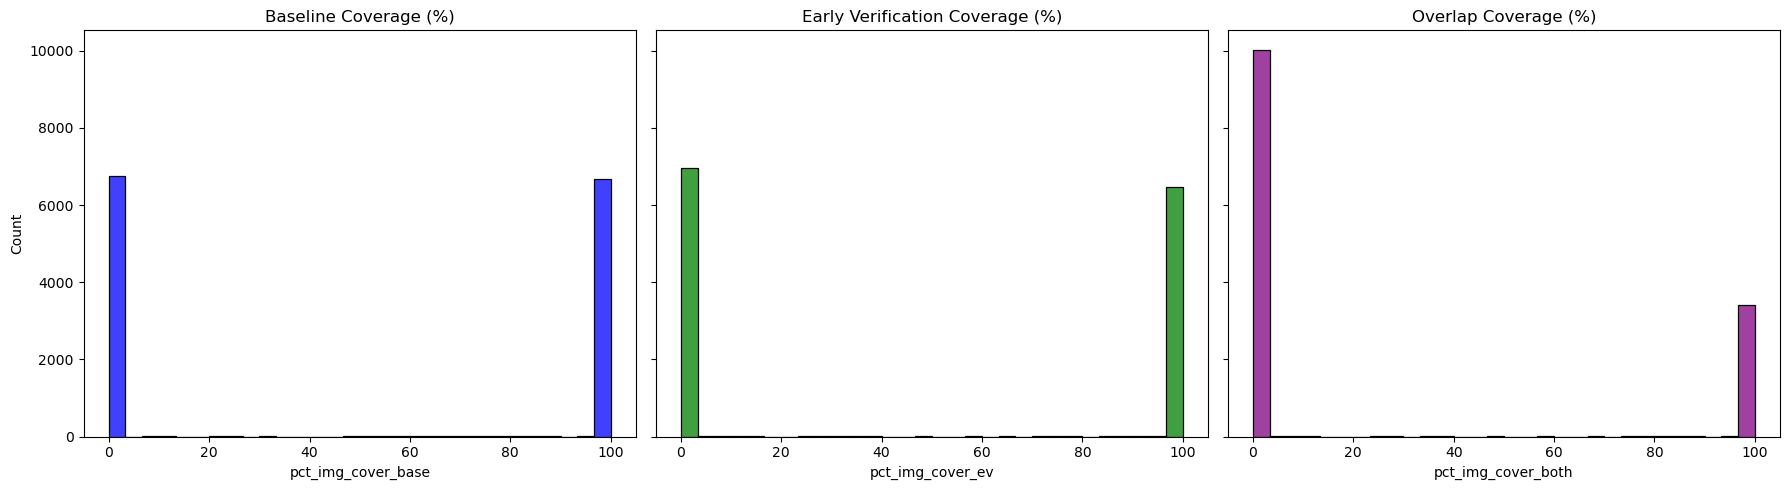

In [48]:
# Histograms
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.histplot(combined_gdf['pct_img_cover_base'], bins=30, ax=axes[0], color='blue')
axes[0].set_title("Baseline Coverage (%)")

sns.histplot(combined_gdf['pct_img_cover_ev'], bins=30, ax=axes[1], color='green')
axes[1].set_title("Early Verification Coverage (%)")

sns.histplot(combined_gdf['pct_img_cover_both'], bins=30, ax=axes[2], color='purple')
axes[2].set_title("Overlap Coverage (%)")

plt.tight_layout()
plt.show()

In [52]:
# Identify zones
no_coverage = combined_gdf[combined_gdf['pct_img_cover_both'] == 0]
print(f"📦 Polygons with 0% overlap coverage: {len(no_coverage)}")

coverage = combined_gdf[combined_gdf['pct_img_cover_both'] > 0]
print(f"📦 Polygons with overlapping coverage: {len(coverage)}")

len(no_coverage) + len(coverage)

📦 Polygons with 0% overlap coverage: 10009
📦 Polygons with overlapping coverage: 3528


13537

## Test on single row

In [24]:
test_row = combined_gdf.iloc[118]
analyze.compute_shared_img_overlap(test_row, debug=True)


⚙️ Processing poly_id: e967dba5-b2bf-41bb-af68-9c7c59836ab5
⬜ Geometry types:
 poly=<class 'shapely.geometry.polygon.Polygon'>,
 base=<class 'NoneType'>,
 ev=<class 'shapely.geometry.polygon.Polygon'>
⚠️ Missing or invalid type of one or more geometries: recording 0 area & % overlap for poly_id: e967dba5-b2bf-41bb-af68-9c7c59836ab5


overlap_area_both     0
pct_img_cover_both    0
dtype: int64

In [25]:
test_poly_geom = test_row['poly_geom']
test_img_geom_base = test_row['img_geom_base']
test_img_geom_ev = test_row['img_geom_ev']

In [26]:
if test_img_geom_base is None:
    print('no img_base_geom!')
else:
    print(test_img_geom_base)

no img_base_geom!


In [27]:
centroid = test_poly_geom.centroid
utm_crs = img_cover.get_utm_crs(centroid.x, centroid.y)
utm_crs

'EPSG:32636'

In [28]:
poly_proj = analyze.reproject_geometry(test_poly_geom, utm_crs)
base_proj = analyze.reproject_geometry(test_img_geom_base, utm_crs)
ev_proj = analyze.reproject_geometry(test_img_geom_ev, utm_crs)

In [29]:
intersection = poly_proj.intersection(base_proj).intersection(ev_proj)

AttributeError: 'NoneType' object has no attribute 'intersection'

In [30]:
print(intersection.geom_type)
print(intersection.is_valid)

Polygon
True


In [31]:
print(f"Intersection area (sq meters): {intersection.area}")

Intersection area (sq meters): 3866.252058457901


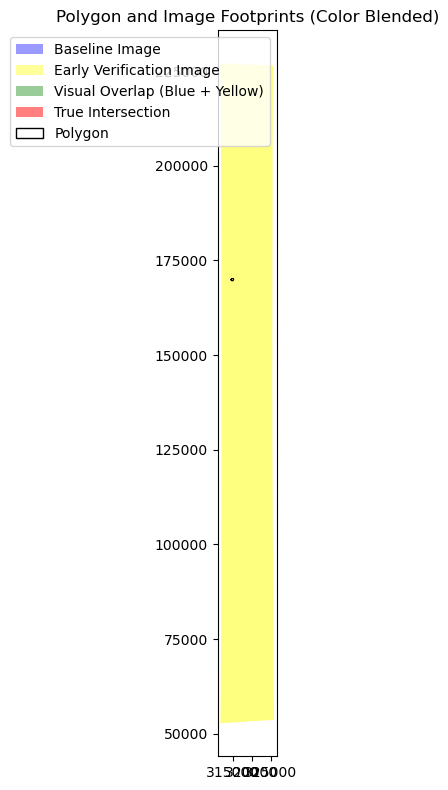

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Reprojected geometries (already in the same CRS)
gdf_poly = gpd.GeoDataFrame(geometry=[poly_proj], crs=utm_crs)
gdf_base = gpd.GeoDataFrame(geometry=[base_proj], crs=utm_crs)
gdf_ev   = gpd.GeoDataFrame(geometry=[ev_proj], crs=utm_crs)

#intersection = poly_proj.intersection(base_proj).intersection(ev_proj)

fig, ax = plt.subplots(figsize=(8,8))

# Plot the EV and baseline image footprints
gdf_base.plot(ax=ax, color='blue', alpha=0.5)
gdf_ev.plot(ax=ax, color='yellow', alpha=0.5)

# Plot the polygon outline
gdf_poly.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

# Get polygon bounds (xmin, ymin, xmax, ymax)
xmin, ymin, xmax, ymax = gdf_poly.total_bounds

# Plot the true intersection of polygon, base image, & EV image
#if not intersection.is_empty:
#    gpd.GeoDataFrame(geometry=[intersection], crs=utm_crs).plot(ax=ax, color='red', alpha=0.5)

## Zoom to polygon extent
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
ax.set_aspect('equal')

# Custom legend
legend_elements = [
    mpatches.Patch(facecolor='blue', alpha=0.4, label='Baseline Image'),
    mpatches.Patch(facecolor='yellow', alpha=0.4, label='Early Verification Image'),
    mpatches.Patch(facecolor='green', alpha=0.4, label='Visual Overlap (Blue + Yellow)'),
    mpatches.Patch(facecolor='red', alpha=0.5, label='True Intersection'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Polygon')
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title("Polygon and Image Footprints (Color Blended)")
plt.tight_layout()
plt.show()

### Aggregate the Area (& % Area) With Coverage at Both Years to the Project Level

In [54]:
combined_gdf[117:120]

,poly_id,project_id,poly_geom,poly_area_ha,best_img_base,img_geom_base,overlap_area_base,pct_img_cover_base,best_img_ev,img_geom_ev,overlap_area_ev,pct_img_cover_ev,overlap_area_both,pct_img_cover_both
117,1a10c9f4-4940-4715-93f1-164d57c61eb7,389aad5b-6577-4cea-bf9f-446dcfd94966,"POLYGON ((31.19677 1.29141, 31.19678 1.2912, 3...",0.386625,Maxar WV02 Image 10300100DE8BBE00,"POLYGON ((31.07613 1.51209, 31.07636 1.46413, ...",0.386625,100.0,Maxar WV02 Image 10300100F9AE3900,"POLYGON ((31.06672 2.03158, 31.06672 2.03089, ...",0.386625,100.0,0.386625,100.0
118,e967dba5-b2bf-41bb-af68-9c7c59836ab5,389aad5b-6577-4cea-bf9f-446dcfd94966,"POLYGON ((31.33516 1.53714, 31.33514 1.53717, ...",2.527293,NaN,None,0.000000,0.0,Maxar WV03 Image 1040010094CD6A00,"POLYGON ((31.43146 1.84578, 31.43147 1.85154, ...",2.527293,100.0,0.000000,0.0
119,77af134d-3981-45fc-988b-95c16dc184af,389aad5b-6577-4cea-bf9f-446dcfd94966,"POLYGON ((31.17725 1.3429, 31.17722 1.34288, 3...",0.311552,Maxar WV02 Image 10300100DFBDF500,"POLYGON ((31.0339 1.49462, 31.03396 1.45226, 3...",0.311552,100.0,Maxar WV03 Image 104001009C720900,"POLYGON ((31.09822 1.41492, 31.09822 1.39754, ...",0.311552,100.0,0.311552,100.0


In [58]:
type(combined_gdf.iloc[0]['pct_img_cover_both'])

numpy.float64

In [62]:
def aggregate_proj_dual_img_cover(combined_gdf, debug=False):
    """
    Aggregates polygon-level data to project level for imagery available at both baseline and early verification time points.

    Args:
        - combined_gdf (DataFrame): Polygon-level image coverage data. Requires the following columns:
            - 'poly_id' (str): unique ID for each polygon
            - 'project_id' (str): unique ID for each project
            - 'poly_area_ha' (float): the area of the polygon in hectares
            - 'overlap_area_both' (float): the area of the polygon that has imagery coverage at both baseline & early verification
            - 'pct_img_cover_both' (float): the percent of the polygon's overall area with imagery coverage at both time points
    Returns:
        - DataFrame: Project-level summary with total area, overlap area, and % coverage
    """

    # Group by project ID
    grouped = combined_gdf.groupby('project_id')

    if debug:
        print(f"🗂️ Analyzing {len(grouped)} projects")

    # Aggregate key metrics
    project_coverage_df = grouped.agg(
        num_polygons=('poly_id', 'count'),
        num_polygons_with_overlap=('pct_img_cover_both', lambda x: (x > 0).sum()),
        num_polygons_no_overlap=('pct_img_cover_both', lambda x: (x == 0).sum()),
        total_project_area_ha=('poly_area_ha', 'sum'),
        total_overlap_area_ha=('overlap_area_both', 'sum')
    ).reset_index()

    # Calculate % of total project area with overlapping coverage at both time points
    project_coverage_df['pct_project_img_cover_both'] = (
        (project_coverage_df['total_overlap_area_ha'] / project_coverage_df['total_project_area_ha']) * 100
    ).round(4)

    if debug:
        print("✅ Aggregation complete.")
    
    return project_coverage_df
   

In [65]:
project_dual_coverage_df = aggregate_proj_dual_img_cover(combined_gdf, debug=True)

🗂️ Analyzing 80 projects
✅ Aggregation complete.


In [67]:
project_dual_coverage_df.sort_values('pct_project_img_cover_both', ascending=False).head(10)

,project_id,num_polygons,num_polygons_with_overlap,num_polygons_no_overlap,total_project_area_ha,total_overlap_area_ha,pct_project_img_cover_both
9,292bbbda-ec32-40e2-a127-3670a052423d,5,5,0,181.113842,181.113842,100.0000
64,cf106374-3dd4-401d-80ba-25b70247381a,1,1,0,208.172736,208.172736,100.0000
40,6ca7c7b3-9109-4f34-8dc5-a64f8c7d558f,9,8,1,34.179136,33.271090,97.3433
13,33274073-8a4e-4eca-8b97-0e8da3833105,8,8,0,112.537513,107.329302,95.3720
19,3a860077-df4c-4e95-8fec-41520c551243,13,13,0,81.462165,76.452071,93.8498
54,a8940698-ff28-456c-b8cd-f7289e612913,290,276,14,226.466458,192.907629,85.1815
28,53f9f5a6-9346-436c-87bb-b5cc86d978c0,10,5,5,74.810957,59.719677,79.8274
0,01918b25-6544-4027-82aa-6703c7c04784,3,3,0,87.491609,69.138218,79.0227
41,71706fe4-0e80-4552-8be2-d6f6a55e13d2,16,2,14,189.432445,148.403138,78.3409
61,c3d2858f-aa3d-458e-8e88-5a7f376e6ef4,58,47,11,63.883193,49.718911,77.8278


In [73]:
print(len(project_dual_coverage_df[project_dual_coverage_df['pct_project_img_cover_both'] >= 70].sort_values('pct_project_img_cover_both', ascending=False)))
project_dual_coverage_df[project_dual_coverage_df['pct_project_img_cover_both'] >= 70].sort_values('pct_project_img_cover_both', ascending=False)

12


,project_id,num_polygons,num_polygons_with_overlap,num_polygons_no_overlap,total_project_area_ha,total_overlap_area_ha,pct_project_img_cover_both
9,292bbbda-ec32-40e2-a127-3670a052423d,5,5,0,181.113842,181.113842,100.0000
64,cf106374-3dd4-401d-80ba-25b70247381a,1,1,0,208.172736,208.172736,100.0000
40,6ca7c7b3-9109-4f34-8dc5-a64f8c7d558f,9,8,1,34.179136,33.271090,97.3433
13,33274073-8a4e-4eca-8b97-0e8da3833105,8,8,0,112.537513,107.329302,95.3720
19,3a860077-df4c-4e95-8fec-41520c551243,13,13,0,81.462165,76.452071,93.8498
54,a8940698-ff28-456c-b8cd-f7289e612913,290,276,14,226.466458,192.907629,85.1815
28,53f9f5a6-9346-436c-87bb-b5cc86d978c0,10,5,5,74.810957,59.719677,79.8274
0,01918b25-6544-4027-82aa-6703c7c04784,3,3,0,87.491609,69.138218,79.0227
41,71706fe4-0e80-4552-8be2-d6f6a55e13d2,16,2,14,189.432445,148.403138,78.3409
61,c3d2858f-aa3d-458e-8e88-5a7f376e6ef4,58,47,11,63.883193,49.718911,77.8278
